# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run126', 'ORACLE.run150', 'ORACLE.run120', 'ORACLE.run138', 'ORACLE.run18', 'ORACLE.run144', 'ORACLE.run132', 'ORACLE.run114'}


{'Wisig_4', 'Wisig_3', 'Wisig_1', 'Wisig_2'}


tensor([[[ 6.7141e-04,  5.7985e-04, -4.0284e-03,  ..., -1.8311e-04,
           3.0213e-03, -3.6622e-04],
         [ 8.2400e-04,  1.1902e-03, -1.3428e-03,  ..., -3.4486e-03,
          -1.8311e-03,  6.1037e-04]],

        [[-3.1129e-03, -3.5096e-03,  1.3428e-03,  ..., -3.2350e-03,
           5.1881e-04,  3.7233e-03],
         [-3.3876e-03,  1.3428e-03, -2.4415e-03,  ..., -3.7538e-03,
          -2.5941e-03, -1.8921e-03]],

        [[ 1.2207e-04, -2.6246e-03,  1.3733e-03,  ...,  5.7985e-04,
           1.2513e-03,  4.8830e-04],
         [ 4.3947e-03, -1.9227e-03, -2.1363e-04,  ..., -1.5259e-04,
          -7.3244e-04, -2.6856e-03]],

        ...,

        [[ 5.1576e-03, -2.8687e-03, -5.0661e-03,  ...,  3.6622e-04,
          -4.7914e-03, -1.2818e-03],
         [ 4.5473e-03, -1.6175e-03, -2.8382e-03,  ...,  4.6083e-03,
           3.0213e-03,  1.0376e-03]],

        [[ 3.1434e-03,  2.1363e-04, -7.0193e-04,  ..., -6.1647e-03,
          -3.8453e-03, -2.1973e-03],
         [-3.0519e-03,  1.4649e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.6007, train_label_loss: 2.7102, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 4163.1451, train_label_loss: 1.6411, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3633.0924, train_label_loss: 1.1501, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 2972.0325, train_label_loss: 0.5994, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 2918.5416, train_label_loss: 0.5839, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 2948.3686, train_label_loss: 0.4204, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 2979.1608, train_label_loss: 0.7932, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 2925.5360, train_label_loss: 0.2815, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 2937.7443, train_label_loss: 0.1786, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 2966.1539, train_label_loss: 0.1142, 


epoch: 1, source_val_acc_label: 0.7421, target_val_acc_label: 0.7926, source_val_label_loss: 1.8515, target_val_label_loss: 309.2335, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.7693, train_label_loss: 0.3631, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3490.5104, train_label_loss: 0.4209, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3449.5519, train_label_loss: 0.5275, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3002.5523, train_label_loss: 0.5343, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2961.3259, train_label_loss: 0.4881, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 2980.7246, train_label_loss: 0.2715, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3009.7749, train_label_loss: 0.3314, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 2973.7685, train_label_loss: 0.1076, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3016.0917, train_label_loss: 0.1602, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3007.9224, train_label_loss: 0.3168, 


epoch: 2, source_val_acc_label: 0.8660, target_val_acc_label: 0.8564, source_val_label_loss: 0.3740, target_val_label_loss: 89.8475, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.7838, train_label_loss: 0.5059, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3542.9188, train_label_loss: 0.7412, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3463.4306, train_label_loss: 0.4553, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 2975.5187, train_label_loss: 0.3294, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2970.0971, train_label_loss: 0.1406, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2952.1386, train_label_loss: 0.1851, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2979.9588, train_label_loss: 0.3458, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2976.2194, train_label_loss: 0.1238, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3001.6840, train_label_loss: 0.2634, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 2998.6161, train_label_loss: 0.3513, 


epoch: 3, source_val_acc_label: 0.8690, target_val_acc_label: 0.8581, source_val_label_loss: 0.3565, target_val_label_loss: 86.1910, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.7802, train_label_loss: 0.0488, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3443.6681, train_label_loss: 0.2676, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3273.5776, train_label_loss: 0.2807, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 2983.8655, train_label_loss: 0.2719, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 2977.5782, train_label_loss: 0.2645, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3001.4958, train_label_loss: 0.2816, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3001.1819, train_label_loss: 0.5646, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 2979.8826, train_label_loss: 0.2742, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 2982.6483, train_label_loss: 0.2793, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3007.2901, train_label_loss: 0.0721, 


epoch: 4, source_val_acc_label: 0.8811, target_val_acc_label: 0.8545, source_val_label_loss: 0.3281, target_val_label_loss: 114.9051, 


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7875, train_label_loss: 0.1145, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3603.1161, train_label_loss: 0.1980, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 2987.6906, train_label_loss: 0.1740, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 2993.8443, train_label_loss: 0.2826, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3003.3557, train_label_loss: 0.1531, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 2998.9519, train_label_loss: 0.2831, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3017.4342, train_label_loss: 0.2714, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2991.8029, train_label_loss: 0.2529, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 2963.2741, train_label_loss: 0.2364, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3002.8764, train_label_loss: 0.3034, 


epoch: 5, source_val_acc_label: 0.8824, target_val_acc_label: 0.8565, source_val_label_loss: 0.3238, target_val_label_loss: 119.2081, 


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7966, train_label_loss: 0.1462, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3528.3751, train_label_loss: 0.2250, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3039.1021, train_label_loss: 0.3684, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2999.1389, train_label_loss: 0.5035, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3008.8698, train_label_loss: 0.2990, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 2996.2960, train_label_loss: 0.1920, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 2985.1274, train_label_loss: 0.1112, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 2976.6036, train_label_loss: 0.1797, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 2979.7951, train_label_loss: 0.2807, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 2988.8054, train_label_loss: 0.1347, 


epoch: 6, source_val_acc_label: 0.8855, target_val_acc_label: 0.8600, source_val_label_loss: 0.3241, target_val_label_loss: 117.2791, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.8078, train_label_loss: 0.2000, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3366.5706, train_label_loss: 0.3681, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3037.0805, train_label_loss: 0.2579, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3013.4273, train_label_loss: 0.2578, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2997.8535, train_label_loss: 0.2050, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 2992.3599, train_label_loss: 0.2902, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3013.3722, train_label_loss: 0.0657, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2980.8086, train_label_loss: 0.1124, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 2999.8232, train_label_loss: 0.2117, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3005.6629, train_label_loss: 0.1955, 


epoch: 7, source_val_acc_label: 0.8857, target_val_acc_label: 0.8599, source_val_label_loss: 0.3186, target_val_label_loss: 115.1947, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.8107, train_label_loss: 0.2414, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3288.6547, train_label_loss: 0.2134, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3013.5580, train_label_loss: 0.2193, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 2987.5145, train_label_loss: 0.1013, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2957.5297, train_label_loss: 0.0817, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3006.8796, train_label_loss: 0.2047, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3011.9219, train_label_loss: 0.1601, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 2994.4969, train_label_loss: 0.1689, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3007.9170, train_label_loss: 0.1672, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 2978.6271, train_label_loss: 0.1711, 


epoch: 8, source_val_acc_label: 0.8903, target_val_acc_label: 0.8615, source_val_label_loss: 0.3152, target_val_label_loss: 112.6509, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.8247, train_label_loss: 0.1342, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3297.4486, train_label_loss: 0.3984, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 2989.6248, train_label_loss: 0.3170, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 2957.2135, train_label_loss: 0.1255, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3000.3332, train_label_loss: 0.2251, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 2981.5116, train_label_loss: 0.0572, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2992.2034, train_label_loss: 0.2173, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3013.3771, train_label_loss: 0.0892, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3014.6691, train_label_loss: 0.2631, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3009.2729, train_label_loss: 0.1616, 


epoch: 9, source_val_acc_label: 0.8917, target_val_acc_label: 0.8616, source_val_label_loss: 0.3167, target_val_label_loss: 115.8759, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.8214, train_label_loss: 0.2377, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3217.4803, train_label_loss: 0.1017, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3017.3494, train_label_loss: 0.0626, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3014.1380, train_label_loss: 0.0447, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3011.4706, train_label_loss: 0.1973, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3041.6114, train_label_loss: 0.1074, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3037.6838, train_label_loss: 0.1273, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 2977.9250, train_label_loss: 0.0615, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 2983.0479, train_label_loss: 0.1241, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 2977.0605, train_label_loss: 0.3238, 


epoch: 10, source_val_acc_label: 0.8871, target_val_acc_label: 0.8639, source_val_label_loss: 0.3266, target_val_label_loss: 113.4318, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.8249, train_label_loss: 0.2249, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3179.3684, train_label_loss: 0.1463, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3019.0552, train_label_loss: 0.0483, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3020.4129, train_label_loss: 0.1930, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3014.7358, train_label_loss: 0.1292, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3019.8730, train_label_loss: 0.0218, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 2991.2946, train_label_loss: 0.0325, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 2969.7161, train_label_loss: 0.2324, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3011.8458, train_label_loss: 0.0438, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 2980.4796, train_label_loss: 0.2056, 


epoch: 11, source_val_acc_label: 0.8955, target_val_acc_label: 0.8693, source_val_label_loss: 0.3139, target_val_label_loss: 114.9686, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.8410, train_label_loss: 0.1317, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3188.3354, train_label_loss: 0.0530, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3009.4060, train_label_loss: 0.2283, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 2997.9083, train_label_loss: 0.0851, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2996.3083, train_label_loss: 0.0463, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 2947.5910, train_label_loss: 0.0592, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 2991.7096, train_label_loss: 0.0142, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2993.2949, train_label_loss: 0.1507, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 2971.8015, train_label_loss: 0.0326, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3003.9424, train_label_loss: 0.1313, 


epoch: 12, source_val_acc_label: 0.8951, target_val_acc_label: 0.8693, source_val_label_loss: 0.3216, target_val_label_loss: 124.8737, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.8350, train_label_loss: 0.3016, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3140.4835, train_label_loss: 0.1115, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 2967.9777, train_label_loss: 0.0734, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3010.3032, train_label_loss: 0.0831, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3032.6619, train_label_loss: 0.1143, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 2992.6236, train_label_loss: 0.2656, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3035.7586, train_label_loss: 0.0904, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 2994.9437, train_label_loss: 0.1556, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3021.7599, train_label_loss: 0.1675, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3014.9970, train_label_loss: 0.1689, 


epoch: 13, source_val_acc_label: 0.8956, target_val_acc_label: 0.8721, source_val_label_loss: 0.3295, target_val_label_loss: 121.9339, 


New best


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.8346, train_label_loss: 0.0763, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3155.4065, train_label_loss: 0.0165, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 2966.4127, train_label_loss: 0.0870, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 2971.7000, train_label_loss: 0.1784, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 2988.3834, train_label_loss: 0.0593, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 2966.1039, train_label_loss: 0.0440, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 2999.2673, train_label_loss: 0.1562, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 2987.6952, train_label_loss: 0.0167, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 2994.1966, train_label_loss: 0.0558, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3017.3912, train_label_loss: 0.1334, 


epoch: 14, source_val_acc_label: 0.8926, target_val_acc_label: 0.8734, source_val_label_loss: 0.3303, target_val_label_loss: 120.2560, 


New best


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.8335, train_label_loss: 0.0270, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 3123.7830, train_label_loss: 0.1274, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 2996.3163, train_label_loss: 0.2464, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 2982.7782, train_label_loss: 0.1936, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 2979.1312, train_label_loss: 0.1268, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 2962.6215, train_label_loss: 0.1239, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3010.1516, train_label_loss: 0.2986, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3001.4690, train_label_loss: 0.0941, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 2990.9266, train_label_loss: 0.2013, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 2971.8941, train_label_loss: 0.0199, 


epoch: 15, source_val_acc_label: 0.8943, target_val_acc_label: 0.8716, source_val_label_loss: 0.3480, target_val_label_loss: 131.5049, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.8394, train_label_loss: 0.1316, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3093.5463, train_label_loss: 0.0505, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2977.3874, train_label_loss: 0.1042, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 3027.0189, train_label_loss: 0.1447, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3033.2282, train_label_loss: 0.0619, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2999.0804, train_label_loss: 0.0985, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 2981.6160, train_label_loss: 0.0192, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 2963.9786, train_label_loss: 0.0201, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 2987.8913, train_label_loss: 0.0717, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 2999.6832, train_label_loss: 0.0659, 


epoch: 16, source_val_acc_label: 0.8957, target_val_acc_label: 0.8749, source_val_label_loss: 0.3446, target_val_label_loss: 144.7315, 


New best


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.8368, train_label_loss: 0.0813, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 2995.9204, train_label_loss: 0.0748, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 2979.0996, train_label_loss: 0.2037, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 3001.0945, train_label_loss: 0.2300, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 3004.9764, train_label_loss: 0.0732, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 2971.5256, train_label_loss: 0.0368, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 2977.2288, train_label_loss: 0.0707, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2997.7684, train_label_loss: 0.0392, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 2946.9903, train_label_loss: 0.0138, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 3003.4366, train_label_loss: 0.1886, 


epoch: 17, source_val_acc_label: 0.8913, target_val_acc_label: 0.8743, source_val_label_loss: 0.3607, target_val_label_loss: 141.7478, 


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.8479, train_label_loss: 0.2822, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 3462.9091, train_label_loss: 0.1358, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 3422.4842, train_label_loss: 0.0257, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3426.9493, train_label_loss: 0.1631, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 3423.8074, train_label_loss: 0.1652, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 3783.1060, train_label_loss: 0.0478, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 3996.7528, train_label_loss: 0.0884, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 3935.0358, train_label_loss: 0.1150, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 3967.3460, train_label_loss: 0.2015, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 3915.8922, train_label_loss: 0.2002, 


epoch: 18, source_val_acc_label: 0.8950, target_val_acc_label: 0.8754, source_val_label_loss: 0.3621, target_val_label_loss: 149.6501, 


New best


epoch: 19, [batch: 1 / 33600], examples_per_second: 1.0603, train_label_loss: 0.0154, 


epoch: 19, [batch: 3360 / 33600], examples_per_second: 3403.8303, train_label_loss: 0.0341, 


epoch: 19, [batch: 6720 / 33600], examples_per_second: 3476.5726, train_label_loss: 0.0581, 


epoch: 19, [batch: 10080 / 33600], examples_per_second: 3697.8702, train_label_loss: 0.0747, 


epoch: 19, [batch: 13440 / 33600], examples_per_second: 3480.8161, train_label_loss: 0.0310, 


epoch: 19, [batch: 16800 / 33600], examples_per_second: 3787.1192, train_label_loss: 0.0421, 


epoch: 19, [batch: 20160 / 33600], examples_per_second: 4290.2193, train_label_loss: 0.0870, 


epoch: 19, [batch: 23520 / 33600], examples_per_second: 4099.3129, train_label_loss: 0.0982, 


epoch: 19, [batch: 26880 / 33600], examples_per_second: 3971.4776, train_label_loss: 0.0419, 


epoch: 19, [batch: 30240 / 33600], examples_per_second: 4130.9284, train_label_loss: 0.2271, 


epoch: 19, source_val_acc_label: 0.8939, target_val_acc_label: 0.8772, source_val_label_loss: 0.3642, target_val_label_loss: 148.1866, 


New best


epoch: 20, [batch: 1 / 33600], examples_per_second: 1.0685, train_label_loss: 0.1168, 


epoch: 20, [batch: 3360 / 33600], examples_per_second: 3269.8143, train_label_loss: 0.1010, 


epoch: 20, [batch: 6720 / 33600], examples_per_second: 3438.2110, train_label_loss: 0.0652, 


epoch: 20, [batch: 10080 / 33600], examples_per_second: 3457.2698, train_label_loss: 0.1863, 


epoch: 20, [batch: 13440 / 33600], examples_per_second: 3206.8137, train_label_loss: 0.0037, 


epoch: 20, [batch: 16800 / 33600], examples_per_second: 3398.7429, train_label_loss: 0.0731, 


epoch: 20, [batch: 20160 / 33600], examples_per_second: 3754.4358, train_label_loss: 0.0177, 


epoch: 20, [batch: 23520 / 33600], examples_per_second: 3652.7055, train_label_loss: 0.0633, 


epoch: 20, [batch: 26880 / 33600], examples_per_second: 3388.9745, train_label_loss: 0.1080, 


epoch: 20, [batch: 30240 / 33600], examples_per_second: 3504.7810, train_label_loss: 0.1907, 


epoch: 20, source_val_acc_label: 0.8962, target_val_acc_label: 0.8763, source_val_label_loss: 0.3592, target_val_label_loss: 143.2985, 


epoch: 21, [batch: 1 / 33600], examples_per_second: 1.0264, train_label_loss: 0.0005, 


epoch: 21, [batch: 3360 / 33600], examples_per_second: 4057.0497, train_label_loss: 0.0373, 


epoch: 21, [batch: 6720 / 33600], examples_per_second: 4262.8972, train_label_loss: 0.0127, 


epoch: 21, [batch: 10080 / 33600], examples_per_second: 3970.5113, train_label_loss: 0.0491, 


epoch: 21, [batch: 13440 / 33600], examples_per_second: 3603.1212, train_label_loss: 0.1505, 


epoch: 21, [batch: 16800 / 33600], examples_per_second: 3377.2216, train_label_loss: 0.0982, 


epoch: 21, [batch: 20160 / 33600], examples_per_second: 3580.2891, train_label_loss: 0.0189, 


epoch: 21, [batch: 23520 / 33600], examples_per_second: 3866.1455, train_label_loss: 0.0027, 


epoch: 21, [batch: 26880 / 33600], examples_per_second: 3467.9923, train_label_loss: 0.1332, 


epoch: 21, [batch: 30240 / 33600], examples_per_second: 3425.5214, train_label_loss: 0.0594, 


epoch: 21, source_val_acc_label: 0.8936, target_val_acc_label: 0.8763, source_val_label_loss: 0.3712, target_val_label_loss: 146.8180, 


epoch: 22, [batch: 1 / 33600], examples_per_second: 1.0364, train_label_loss: 0.0051, 


epoch: 22, [batch: 3360 / 33600], examples_per_second: 3954.2248, train_label_loss: 0.1226, 


epoch: 22, [batch: 6720 / 33600], examples_per_second: 4458.2426, train_label_loss: 0.1036, 


epoch: 22, [batch: 10080 / 33600], examples_per_second: 4093.9942, train_label_loss: 0.1069, 


epoch: 22, [batch: 13440 / 33600], examples_per_second: 3949.5527, train_label_loss: 0.0245, 


epoch: 22, [batch: 16800 / 33600], examples_per_second: 4297.8682, train_label_loss: 0.1240, 


epoch: 22, [batch: 20160 / 33600], examples_per_second: 4076.7988, train_label_loss: 0.0626, 


epoch: 22, [batch: 23520 / 33600], examples_per_second: 2954.6882, train_label_loss: 0.0334, 


epoch: 22, [batch: 26880 / 33600], examples_per_second: 3192.6606, train_label_loss: 0.0180, 


epoch: 22, [batch: 30240 / 33600], examples_per_second: 3447.3700, train_label_loss: 0.1527, 


epoch: 22, source_val_acc_label: 0.8958, target_val_acc_label: 0.8750, source_val_label_loss: 0.3836, target_val_label_loss: 148.2742, 


epoch: 23, [batch: 1 / 33600], examples_per_second: 0.8338, train_label_loss: 0.0059, 


epoch: 23, [batch: 3360 / 33600], examples_per_second: 3417.8550, train_label_loss: 0.0950, 


epoch: 23, [batch: 6720 / 33600], examples_per_second: 3399.0632, train_label_loss: 0.0372, 


epoch: 23, [batch: 10080 / 33600], examples_per_second: 3943.5697, train_label_loss: 0.0386, 


epoch: 23, [batch: 13440 / 33600], examples_per_second: 3879.8527, train_label_loss: 0.0387, 


epoch: 23, [batch: 16800 / 33600], examples_per_second: 4167.1823, train_label_loss: 0.0192, 


epoch: 23, [batch: 20160 / 33600], examples_per_second: 4722.4986, train_label_loss: 0.0417, 


epoch: 23, [batch: 23520 / 33600], examples_per_second: 3822.5457, train_label_loss: 0.0617, 


epoch: 23, [batch: 26880 / 33600], examples_per_second: 3867.7841, train_label_loss: 0.0377, 


epoch: 23, [batch: 30240 / 33600], examples_per_second: 3819.2982, train_label_loss: 0.0267, 


epoch: 23, source_val_acc_label: 0.8956, target_val_acc_label: 0.8784, source_val_label_loss: 0.3789, target_val_label_loss: 146.1480, 


New best


epoch: 24, [batch: 1 / 33600], examples_per_second: 0.7382, train_label_loss: 0.1378, 


epoch: 24, [batch: 3360 / 33600], examples_per_second: 2989.6211, train_label_loss: 0.0100, 


epoch: 24, [batch: 6720 / 33600], examples_per_second: 2994.6732, train_label_loss: 0.1161, 


epoch: 24, [batch: 10080 / 33600], examples_per_second: 2966.9910, train_label_loss: 0.0744, 


epoch: 24, [batch: 13440 / 33600], examples_per_second: 2974.1693, train_label_loss: 0.0823, 


epoch: 24, [batch: 16800 / 33600], examples_per_second: 3272.1493, train_label_loss: 0.0230, 


epoch: 24, [batch: 20160 / 33600], examples_per_second: 3609.4789, train_label_loss: 0.0023, 


epoch: 24, [batch: 23520 / 33600], examples_per_second: 2975.7873, train_label_loss: 0.0218, 


epoch: 24, [batch: 26880 / 33600], examples_per_second: 3216.9671, train_label_loss: 0.0364, 


epoch: 24, [batch: 30240 / 33600], examples_per_second: 3570.4163, train_label_loss: 0.1395, 


epoch: 24, source_val_acc_label: 0.8926, target_val_acc_label: 0.8709, source_val_label_loss: 0.3951, target_val_label_loss: 146.0559, 


epoch: 25, [batch: 1 / 33600], examples_per_second: 0.7386, train_label_loss: 0.0359, 


epoch: 25, [batch: 3360 / 33600], examples_per_second: 3020.5472, train_label_loss: 0.0127, 


epoch: 25, [batch: 6720 / 33600], examples_per_second: 3041.5944, train_label_loss: 0.0083, 


epoch: 25, [batch: 10080 / 33600], examples_per_second: 2960.9455, train_label_loss: 0.0171, 


epoch: 25, [batch: 13440 / 33600], examples_per_second: 2963.6520, train_label_loss: 0.0202, 


epoch: 25, [batch: 16800 / 33600], examples_per_second: 3236.3043, train_label_loss: 0.0378, 


epoch: 25, [batch: 20160 / 33600], examples_per_second: 3558.0293, train_label_loss: 0.0363, 


epoch: 25, [batch: 23520 / 33600], examples_per_second: 3075.1811, train_label_loss: 0.0442, 


epoch: 25, [batch: 26880 / 33600], examples_per_second: 3267.5134, train_label_loss: 0.1488, 


epoch: 25, [batch: 30240 / 33600], examples_per_second: 3588.0404, train_label_loss: 0.0260, 


epoch: 25, source_val_acc_label: 0.8952, target_val_acc_label: 0.8736, source_val_label_loss: 0.3907, target_val_label_loss: 160.0316, 


epoch: 26, [batch: 1 / 33600], examples_per_second: 0.7482, train_label_loss: 0.0412, 


epoch: 26, [batch: 3360 / 33600], examples_per_second: 2965.1690, train_label_loss: 0.0041, 


epoch: 26, [batch: 6720 / 33600], examples_per_second: 2990.8355, train_label_loss: 0.0072, 


epoch: 26, [batch: 10080 / 33600], examples_per_second: 3010.2935, train_label_loss: 0.0309, 


epoch: 26, [batch: 13440 / 33600], examples_per_second: 2966.4841, train_label_loss: 0.0185, 


epoch: 26, [batch: 16800 / 33600], examples_per_second: 3218.5847, train_label_loss: 0.1197, 


epoch: 26, [batch: 20160 / 33600], examples_per_second: 3596.6118, train_label_loss: 0.0071, 


epoch: 26, [batch: 23520 / 33600], examples_per_second: 3088.2786, train_label_loss: 0.0389, 


epoch: 26, [batch: 26880 / 33600], examples_per_second: 3233.2326, train_label_loss: 0.0776, 


epoch: 26, [batch: 30240 / 33600], examples_per_second: 3550.2054, train_label_loss: 0.0194, 


epoch: 26, source_val_acc_label: 0.8949, target_val_acc_label: 0.8731, source_val_label_loss: 0.3888, target_val_label_loss: 172.0411, 


epoch: 27, [batch: 1 / 33600], examples_per_second: 0.7459, train_label_loss: 0.1133, 


epoch: 27, [batch: 3360 / 33600], examples_per_second: 2993.0096, train_label_loss: 0.0067, 


epoch: 27, [batch: 6720 / 33600], examples_per_second: 2977.2971, train_label_loss: 0.2406, 


epoch: 27, [batch: 10080 / 33600], examples_per_second: 3011.4351, train_label_loss: 0.0050, 


epoch: 27, [batch: 13440 / 33600], examples_per_second: 3007.0514, train_label_loss: 0.0153, 


epoch: 27, [batch: 16800 / 33600], examples_per_second: 3171.3528, train_label_loss: 0.1642, 


epoch: 27, [batch: 20160 / 33600], examples_per_second: 3547.6029, train_label_loss: 0.0100, 


epoch: 27, [batch: 23520 / 33600], examples_per_second: 3138.1702, train_label_loss: 0.0113, 


epoch: 27, [batch: 26880 / 33600], examples_per_second: 3191.4258, train_label_loss: 0.0142, 


epoch: 27, [batch: 30240 / 33600], examples_per_second: 3569.2426, train_label_loss: 0.0456, 


epoch: 27, source_val_acc_label: 0.8931, target_val_acc_label: 0.8728, source_val_label_loss: 0.4025, target_val_label_loss: 163.5089, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

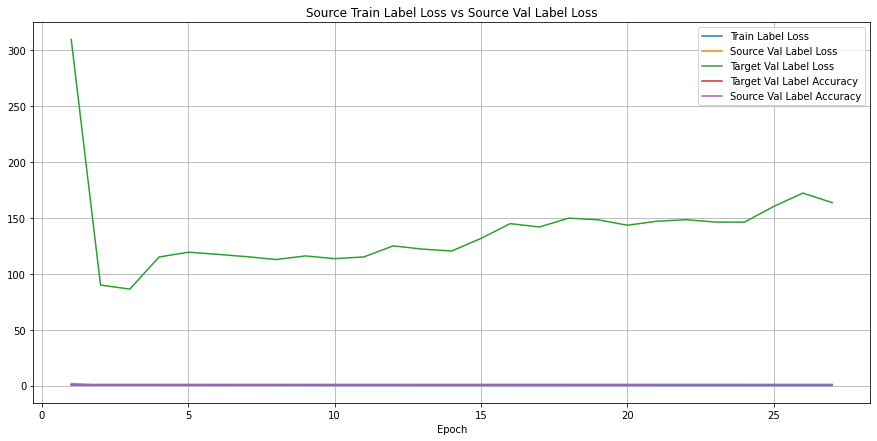

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

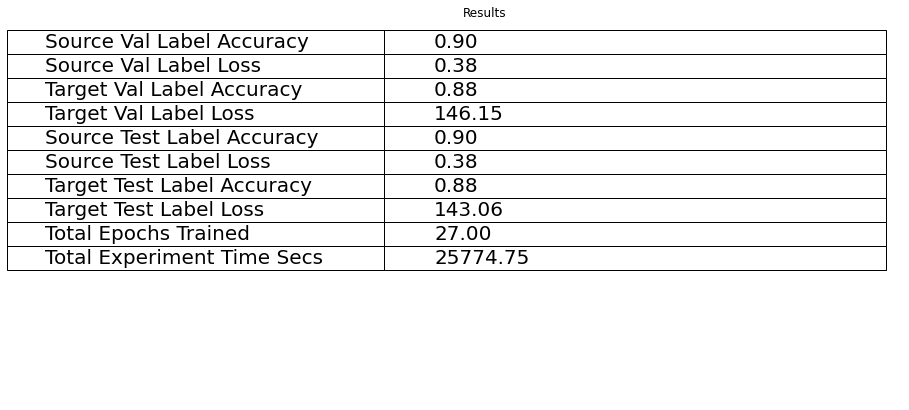

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

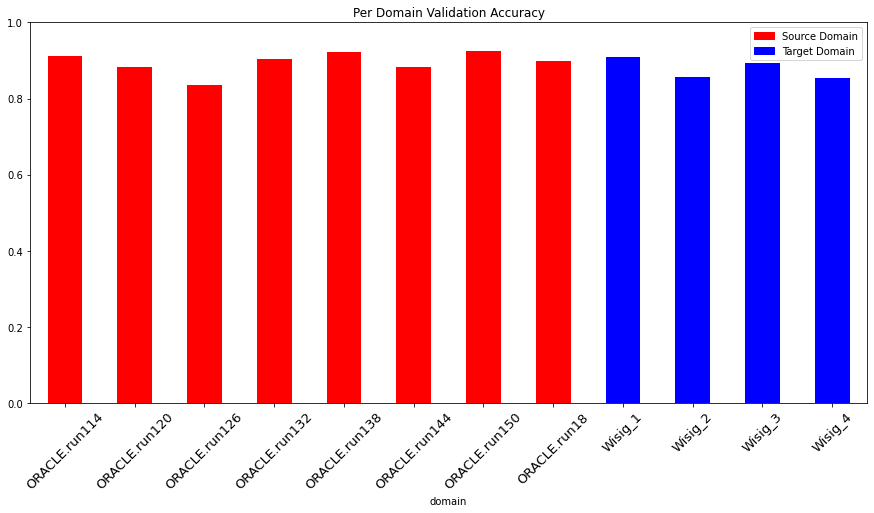

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.896015625 Target Test Label Accuracy: 0.8785908385093167
Source Val Label Accuracy: 0.8955533854166666 Target Val Label Accuracy: 0.8784024841437632


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL